In [1]:
import numpy 
import torch 
import torch.nn as nn 
from torch.nn import Softmax
from torcheval.metrics import MulticlassAccuracy, MulticlassConfusionMatrix 
from torch_geometric.datasets import Planetoid 
from torch_geometric.nn import GCNConv 
from torch_geometric.transforms import RandomNodeSplit 
import matplotlib.pyplot as plt 
import os

In [2]:
num_val = 200
num_test = 500

cora = Planetoid(
    root=".",
    name="Cora",
    transform=RandomNodeSplit(
        num_val=num_val,
        num_test=num_test,
    )
)

data = cora[0]

print('Number of nodes:', data.x.shape[0])
print('Number of edges:', data.edge_index.shape[1])
print('Number of features:', cora.num_features)
print('Number of classes:', cora.num_classes)

Processing...


Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


Done!


In [4]:
class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(cora.num_features, 500)
        self.conv2 = GCNConv(500, 100)
        self.conv3 = GCNConv(100, cora.num_classes)
        self.classifier = Softmax(dim=1)

    # Task 4
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()
        h = self.classifier(h)

        return h

In [5]:
def train(model, optimizer, criterion, data):
    # Train the model
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

    return train_loss, val_loss

In [6]:
def eval(model, data, data_mask):
    model.eval()

    with torch.no_grad():
        out = model(data.x, data.edge_index)
    
    predicted_labels = out.argmax(dim=1)[data_mask]

    # Evaluate model accuracy
    y = data.y[data_mask]
    acc_metric = MulticlassAccuracy()
    acc_metric.update(predicted_labels, y)

    # Evaluate confusion matrix
    cf_metric = MulticlassConfusionMatrix(cora.num_classes)
    cf_metric.update(predicted_labels, y)

    return acc_metric.compute(), cf_metric.compute()

In [7]:
def train_cora(test_pc, epochs):
  # Split the dataset
  num_test = int(cora.num_features * test_pc)
  num_val = int(cora.num_features * 0.1)

  dataset = Planetoid(
      ".",
      "Cora",
      split='geom-gcn',
      transform = RandomNodeSplit(
        num_val=num_val,
        num_test=num_test,
      )
  )
  data = dataset[0]

  # Define the model
  model = GCN()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss()

  train_loss_arr = []
  val_loss_arr = []
  test_acc_arr = []

  # Training
  patience = 0
  epsilon = 0.0001
  for epoch in range(epochs):
    train_loss, val_loss = train(model, optimizer, criterion, data)
    train_loss_arr.append(train_loss.detach().numpy())

    if epoch == 0 or (min_val_loss - val_loss) > epsilon:
      min_val_loss = val_loss
      patience = 0
    else:
      patience += 1
      if patience >= 5:
        break

    val_loss_arr.append(val_loss.detach().numpy())

    # Evaluation
    test_acc, test_cf = eval(model, data, data.test_mask)
    test_acc_arr.append(test_acc)

    print(f'Epoch: {epoch} \t Training loss: {train_loss} \t Validation loss: {val_loss} \t Test accuracy: {test_acc}')

  return train_loss_arr, val_loss_arr, test_acc_arr, test_cf

In [8]:
train_loss_arr, val_loss_arr, test_acc_arr, test_cf = train_cora(0.3, 100)



Processing...
Done!


Epoch: 0 	 Training loss: 1.9497097730636597 	 Validation loss: 1.948683738708496 	 Test accuracy: 0.34032633900642395
Epoch: 1 	 Training loss: 1.8007444143295288 	 Validation loss: 1.8183202743530273 	 Test accuracy: 0.5221444964408875
Epoch: 2 	 Training loss: 1.7569403648376465 	 Validation loss: 1.7806345224380493 	 Test accuracy: 0.631701648235321
Epoch: 3 	 Training loss: 1.7699557542800903 	 Validation loss: 1.7690385580062866 	 Test accuracy: 0.7738927602767944
Epoch: 4 	 Training loss: 1.7077211141586304 	 Validation loss: 1.7256563901901245 	 Test accuracy: 0.8531468510627747
Epoch: 5 	 Training loss: 1.677321195602417 	 Validation loss: 1.7011692523956299 	 Test accuracy: 0.808857798576355
Epoch: 6 	 Training loss: 1.6775542497634888 	 Validation loss: 1.7028254270553589 	 Test accuracy: 0.8205128312110901
Epoch: 7 	 Training loss: 1.6629353761672974 	 Validation loss: 1.6857479810714722 	 Test accuracy: 0.8578088283538818
Epoch: 8 	 Training loss: 1.6448065042495728 	 Vali

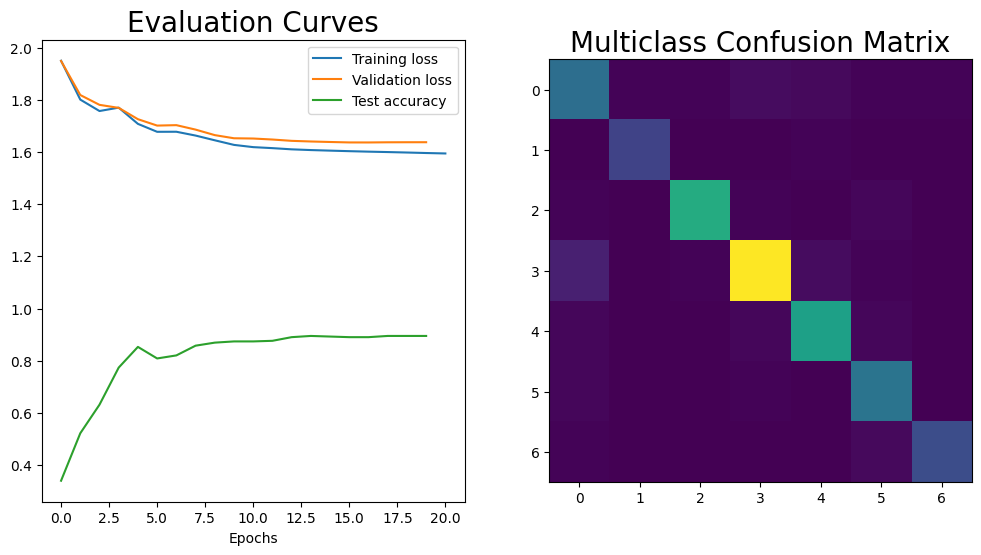


Training loss: 1.5943396091461182
Test accuracy: 0.8951048851013184


In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].plot(train_loss_arr, label='Training loss')
ax[0].plot(val_loss_arr, label='Validation loss')
ax[0].plot(test_acc_arr, label='Test accuracy')

ax[0].legend()
ax[0].set_title('Evaluation Curves', fontsize=20)
ax[0].set_xlabel('Epochs')

ax[1].imshow(test_cf)
ax[1].set_title('Multiclass Confusion Matrix', fontsize=20)

plt.show()

print(f'\nTraining loss: {train_loss_arr[-1]}')
print(f'Test accuracy: {test_acc_arr[-1]}')


----------------Split ratio: 0.8:0.1:0.1------------------
Epoch: 0 	 Training loss: 1.9494730234146118 	 Validation loss: 1.9514857530593872 	 Test accuracy: 0.3986014127731323
Epoch: 1 	 Training loss: 1.8018001317977905 	 Validation loss: 1.797777771949768 	 Test accuracy: 0.4545454680919647
Epoch: 2 	 Training loss: 1.7688040733337402 	 Validation loss: 1.7732621431350708 	 Test accuracy: 0.7902097702026367
Epoch: 3 	 Training loss: 1.7158912420272827 	 Validation loss: 1.6997917890548706 	 Test accuracy: 0.8881118893623352
Epoch: 4 	 Training loss: 1.6818773746490479 	 Validation loss: 1.67262864112854 	 Test accuracy: 0.8951048851013184
Epoch: 5 	 Training loss: 1.663357138633728 	 Validation loss: 1.6627540588378906 	 Test accuracy: 0.9230769276618958
Epoch: 6 	 Training loss: 1.6412293910980225 	 Validation loss: 1.6492185592651367 	 Test accuracy: 0.8951048851013184
Epoch: 7 	 Training loss: 1.6262978315353394 	 Validation loss: 1.6373716592788696 	 Test accuracy: 0.888111889

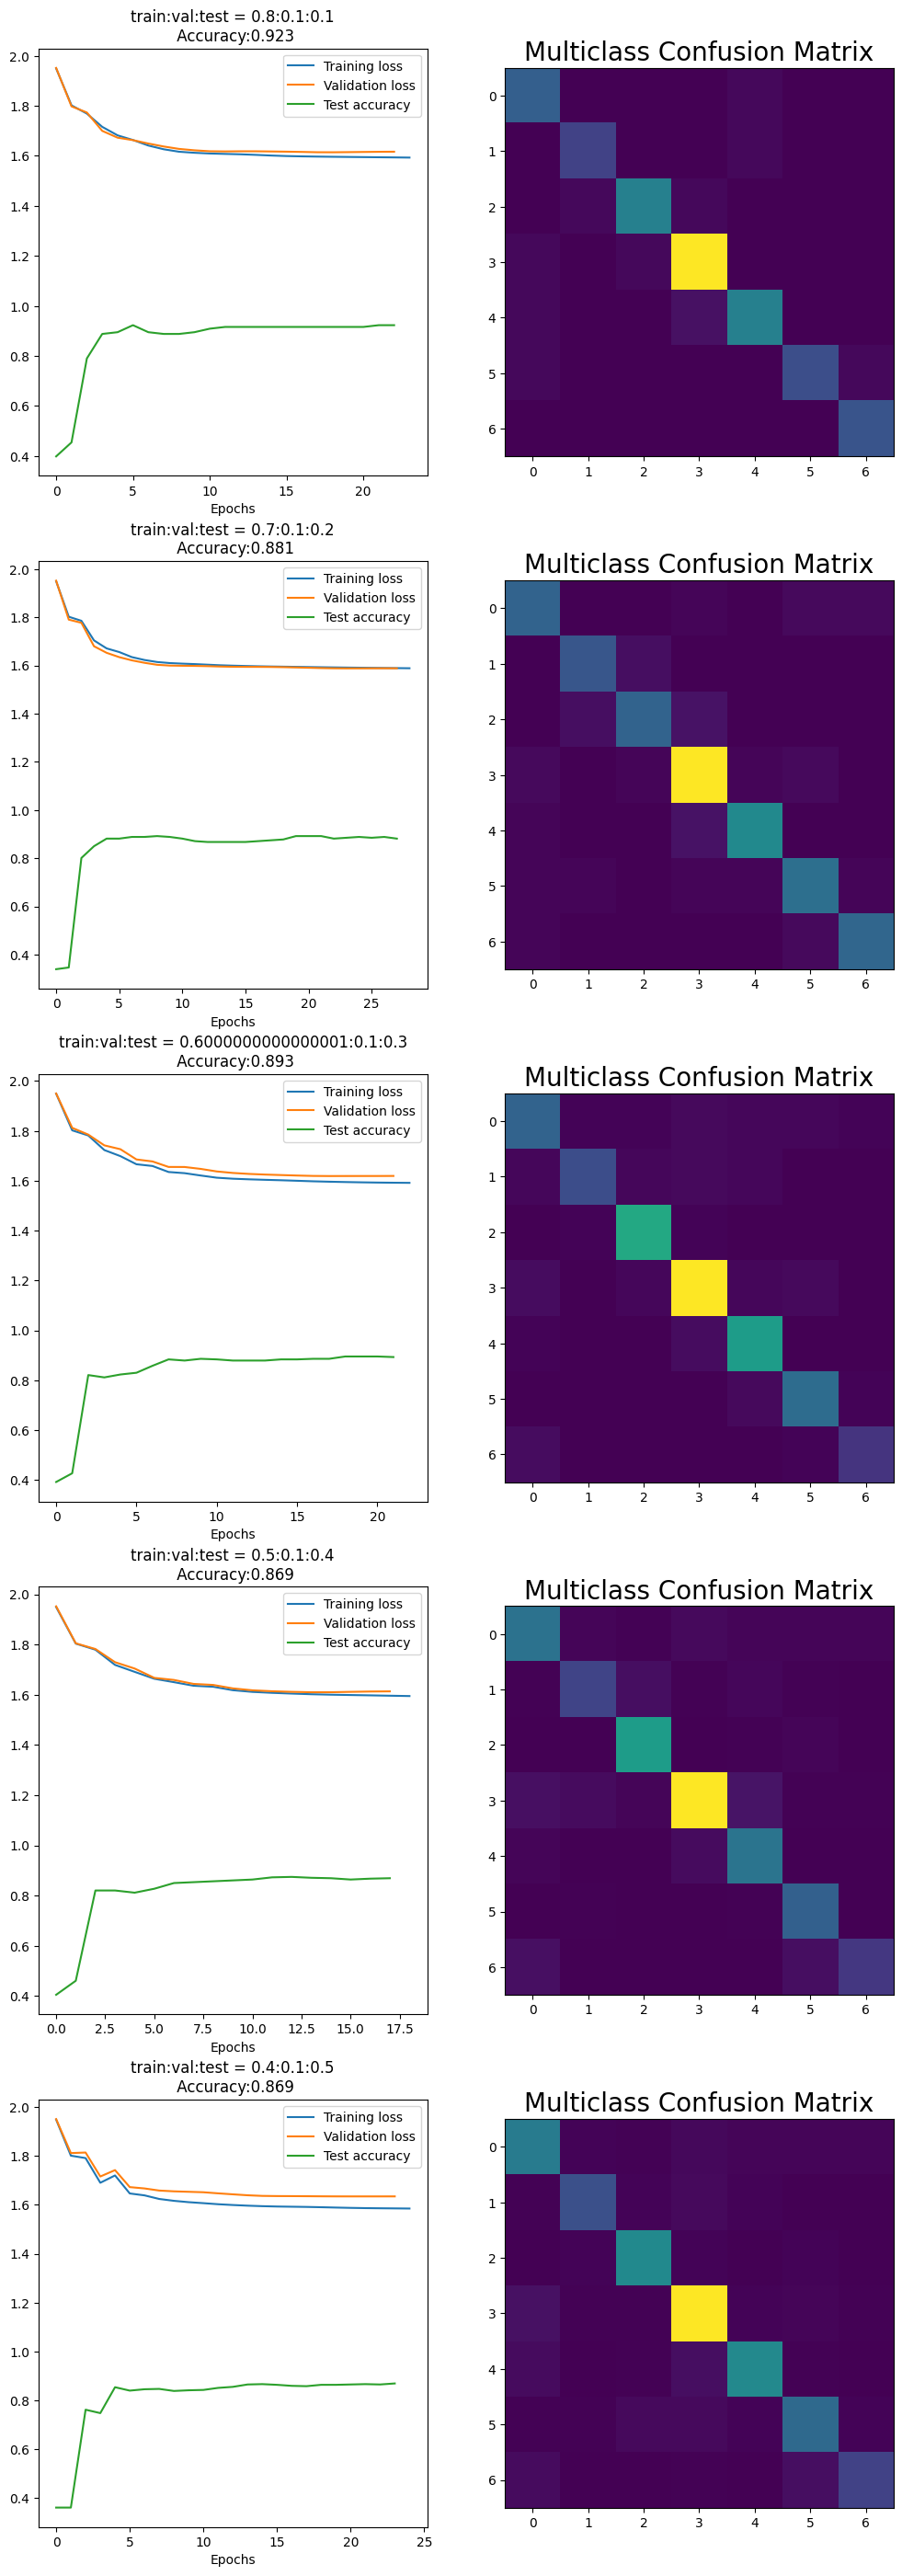

In [10]:
split_ratio_arr = [0.1, 0.2, 0.3, 0.4, 0.5]

fig, ax = plt.subplots(5, 2, figsize = (12, 35))

for i in range(len(split_ratio_arr)):
  print()
  print(f"----------------Split ratio: {0.9 - split_ratio_arr[i]}:0.1:{split_ratio_arr[i]}------------------")
  train_loss_arr, val_loss_arr, test_acc_arr, test_cf = train_cora(split_ratio_arr[i], 100)

  ax[i, 0].plot(train_loss_arr, label='Training loss')
  ax[i, 0].plot(val_loss_arr, label='Validation loss')
  ax[i, 0].plot(test_acc_arr, label='Test accuracy')

  ax[i, 0].legend()
  ax[i, 0].set_title(f'train:val:test = {0.9 - split_ratio_arr[i]}:0.1:{split_ratio_arr[i]}\n Accuracy:{test_acc_arr[-1]:.3f}')
  ax[i, 0].set_xlabel('Epochs')

  ax[i, 1].imshow(test_cf)
  ax[i, 1].set_title("Multiclass Confusion Matrix", fontsize=20)